## setup and basic analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Dict, List, Tuple, Optional

class TransplantStudyAnalyzer:
    def __init__(self, df: pd.DataFrame):
        self.raw_df = df
        # Define visit identifiers based on completion flags
        self.visit_identifiers = {
            1: 'ast_transition_readiness_assessment_tool_late_tran_complete',
            2: 'brief_2_behavior_rating_inventory_of_executive_fun_complete',
            3: ['gad7_anxiety_complete', 'phq9_modified_for_teens_complete'],
            4: ['social_needs_patient_questionnaire_complete', 'pittsburgh_sleep_quality_index_psqi_complete'],
            5: 'pedsql_young_adult_quality_of_life_inventory_v40_y_complete',
            6: 'brief_2_behavior_rating_inventory_of_executiv_4875_complete',
            7: ['v2_gad_7_anxiety_complete', 'v2_phq9_modified_for_teens_complete'],
            8: 'transition_readiness_checklist_late_transition_17_complete',
            9: 'ast_transition_readiness_assessment_tool_late_tran_complete'
        }

        # Define domain columns
        self.domain_columns = {
            'Medical Knowledge': ['mt1_v2_v2', 'mt2_v2_v2', 'mt3_v2_v2', 'mt4_v2_v2', 'mt5_v2_v2'],
            'Medication Management': ['mm6_v2_v2', 'mm7_v2_v2', 'mm8_v2_v2', 'mm9_v2_v2'],
            'Healthcare Navigation': ['ad10_v2_v2', 'ad11_v2_v2', 'ad12_v2_v2', 'ad13_v2_v2'],
            'Self-Advocacy': ['rb16_v2_v2', 'rb17_v2_v2']
        }

        # Clean and prepare data
        self.clean_df = self._preprocess_data()

    def _preprocess_data(self):
        """Clean and prepare data for analysis"""
        df = self.raw_df.copy()

        # Convert date columns
        date_cols = [col for col in df.columns if 'date' in col.lower() or 'timestamp' in col.lower()]
        for col in date_cols:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')

        # Convert numeric columns
        score_cols = [
            'ast_total_score',
            'score_v2_85d59c',  # GAD-7
            'phq_9_severity_score',  # PHQ-9
            'global_psqi_score'  # Sleep quality
        ]

        for col in score_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        # Convert domain columns
        for domain_cols in self.domain_columns.values():
            for prefix in domain_cols:
                cols = [col for col in df.columns if col.startswith(prefix)]
                for col in cols:
                    df[col] = pd.to_numeric(df[col], errors='coerce')

        return df

    def analyze_demographics(self):
        """Analyze demographic information"""
        demographics = {
            'total_patients': len(self.clean_df),
            'age': {
                'mean': self.clean_df['ba_age'].apply(pd.to_numeric, errors='coerce').mean(),
                'std': self.clean_df['ba_age'].apply(pd.to_numeric, errors='coerce').std(),
                'range': (
                    self.clean_df['ba_age'].apply(pd.to_numeric, errors='coerce').min(),
                    self.clean_df['ba_age'].apply(pd.to_numeric, errors='coerce').max()
                )
            },
            'gender': self.clean_df['ba_gender'].value_counts().to_dict()
        }
        return demographics

    def analyze_ast_scores(self):
        """Analyze AST scores"""
        ast_data = self.clean_df['ast_total_score'].dropna()

        results = {
            'summary': {
                'n': len(ast_data),
                'mean': ast_data.mean(),
                'std': ast_data.std(),
                'median': ast_data.median(),
                'range': (ast_data.min(), ast_data.max())
            },
            'completion_rate': (len(ast_data) / len(self.clean_df)) * 100,
            'score_distribution': {
                'below_mean': (ast_data < ast_data.mean()).sum(),
                'above_mean': (ast_data >= ast_data.mean()).sum()
            }
        }

        # Add quartile information
        results['quartiles'] = {
            '25th': ast_data.quantile(0.25),
            'median': ast_data.quantile(0.50),
            '75th': ast_data.quantile(0.75)
        }

        return results

    def analyze_domain_scores(self):
        """Analyze scores across domains"""
        results = {}

        for domain, col_prefixes in self.domain_columns.items():
            domain_data = pd.DataFrame()

            for prefix in col_prefixes:
                cols = [col for col in self.clean_df.columns if col.startswith(prefix)]
                if cols:
                    data = self.clean_df[cols].apply(pd.to_numeric, errors='coerce')
                    domain_data = pd.concat([domain_data, data], axis=1)

            if not domain_data.empty:
                results[domain] = {
                    'mean': domain_data.mean().mean(),
                    'std': domain_data.std().mean(),
                    'completion_rate': (domain_data.notna().sum().sum() /
                                      (domain_data.shape[0] * domain_data.shape[1]) * 100),
                    'items_completed': domain_data.notna().sum().sum(),
                    'total_items': domain_data.shape[0] * domain_data.shape[1]
                }

        return results

    def analyze_mental_health(self):
        """Analyze mental health measures (GAD-7 and PHQ-9)"""
        mental_health = {
            'GAD-7': self._analyze_mental_health_measure('score_v2_85d59c', 'GAD-7'),
            'PHQ-9': self._analyze_mental_health_measure('phq_9_severity_score', 'PHQ-9')
        }
        return mental_health

    def _analyze_mental_health_measure(self, column: str, measure_type: str):
        """Helper function to analyze mental health measures"""
        data = self.clean_df[column].dropna()

        if len(data) == 0:
            return None

        results = {
            'mean': data.mean(),
            'std': data.std(),
            'median': data.median(),
            'range': (data.min(), data.max()),
            'completion_rate': (len(data) / len(self.clean_df)) * 100
        }

        # Add severity categories
        if measure_type == 'GAD-7':
            results['severity'] = {
                'minimal': (data <= 4).sum(),
                'mild': ((data > 4) & (data <= 9)).sum(),
                'moderate': ((data > 9) & (data <= 14)).sum(),
                'severe': (data > 14).sum()
            }
        elif measure_type == 'PHQ-9':
            results['severity'] = {
                'minimal': (data <= 4).sum(),
                'mild': ((data > 4) & (data <= 9)).sum(),
                'moderate': ((data > 9) & (data <= 14)).sum(),
                'moderately_severe': ((data > 14) & (data <= 19)).sum(),
                'severe': (data > 19).sum()
            }

        return results

    def create_visualizations(self):
        """Create comprehensive visualization suite"""
        figs = {}

        # 1. AST Score Distribution
        fig, ax = plt.subplots(figsize=(10, 6))
        ast_data = self.clean_df['ast_total_score'].dropna()
        if len(ast_data) > 0:
            sns.histplot(ast_data, ax=ax)
            ax.axvline(ast_data.mean(), color='r', linestyle='--', label='Mean')
            ax.axvline(ast_data.median(), color='g', linestyle='--', label='Median')
            ax.set_title('Distribution of AST Scores')
            ax.set_xlabel('Score')
            ax.set_ylabel('Frequency')
            ax.legend()
        figs['ast_distribution'] = fig

        # 2. Domain Scores
        domain_scores = self.analyze_domain_scores()
        if domain_scores:
            fig, ax = plt.subplots(figsize=(12, 6))
            domains = list(domain_scores.keys())
            means = [scores['mean'] for scores in domain_scores.values()]

            ax.bar(range(len(domains)), means)
            ax.set_xticks(range(len(domains)))
            ax.set_xticklabels(domains, rotation=45)
            ax.set_title('Mean Domain Scores')
            ax.set_ylabel('Score')
            figs['domain_scores'] = fig

        # 3. Mental Health Scores
        mental_health = self.analyze_mental_health()
        if mental_health['GAD-7'] and mental_health['PHQ-9']:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

            # GAD-7 Severity Distribution
            labels = list(mental_health['GAD-7']['severity'].keys())
            sizes = list(mental_health['GAD-7']['severity'].values())
            ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
            ax1.set_title('GAD-7 Severity Distribution')

            # PHQ-9 Severity Distribution
            labels = list(mental_health['PHQ-9']['severity'].keys())
            sizes = list(mental_health['PHQ-9']['severity'].values())
            ax2.pie(sizes, labels=labels, autopct='%1.1f%%')
            ax2.set_title('PHQ-9 Severity Distribution')

            figs['mental_health'] = fig

        return figs

    def generate_report(self):
        """Generate comprehensive analysis report"""
        report = {
            'demographics': self.analyze_demographics(),
            'ast_analysis': self.analyze_ast_scores(),
            'domain_analysis': self.analyze_domain_scores(),
            'mental_health': self.analyze_mental_health()
        }
        return report

    def print_summary(self):
        """Print analysis summary"""
        report = self.generate_report()

        print("\n=== TRANSPLANT STUDY ANALYSIS SUMMARY ===\n")

        # Demographics
        demo = report['demographics']
        print("Demographics:")
        print(f"Total participants: {demo['total_patients']}")
        print(f"Age range: {demo['age']['range'][0]:.1f} - {demo['age']['range'][1]:.1f} years")
        print(f"Mean age: {demo['age']['mean']:.1f} years (SD: {demo['age']['std']:.1f})")

        # AST Scores
        ast = report['ast_analysis']
        print("\nAST Scores Summary:")
        print(f"Number of participants: {ast['summary']['n']}")
        print(f"Mean score: {ast['summary']['mean']:.2f} (SD: {ast['summary']['std']:.2f})")
        print(f"Score range: {ast['summary']['range'][0]:.1f} - {ast['summary']['range'][1]:.1f}")
        print(f"Completion rate: {ast['completion_rate']:.1f}%")

        # Domain Scores
        print("\nDomain Scores:")
        for domain, scores in report['domain_analysis'].items():
            print(f"\n{domain}:")
            print(f"  Mean: {scores['mean']:.2f} (SD: {scores['std']:.2f})")
            print(f"  Completion Rate: {scores['completion_rate']:.1f}%")

        # Mental Health
        print("\nMental Health Measures:")
        mh = report['mental_health']
        for measure, data in mh.items():
            if data:
                print(f"\n{measure}:")
                print(f"  Mean score: {data['mean']:.2f} (SD: {data['std']:.2f})")
                print(f"  Completion rate: {data['completion_rate']:.1f}%")
                print("  Severity distribution:")
                for category, count in data['severity'].items():
                    print(f"    {category}: {count}")

## Advanced analysis

In [ ]:

class TransplantStudyAdvancedAnalysis:
    def __init__(self, base_analyzer):
        """Initialize with base analyzer instance"""
        self.base = base_analyzer
        self.df = base_analyzer.clean_df

    def analyze_longitudinal_changes(self):
        """Analyze changes between paired visits"""
        visit_pairs = {
            'AST_Readiness': (1, 9),
            'BRIEF': (2, 6),
            'Mental_Health': (3, 7)
        }

        changes = {}
        for measure, (visit1, visit2) in visit_pairs.items():
            changes[measure] = self._analyze_visit_pair(visit1, visit2)

        return changes

    def _analyze_visit_pair(self, visit1: int, visit2: int) -> Dict:
        """Analyze changes between two visits"""
        visit1_mask = self.df[self.base.visit_identifiers[visit1]] == 2
        visit2_mask = self.df[self.base.visit_identifiers[visit2]] == 2

        visit1_data = self.df[visit1_mask]
        visit2_data = self.df[visit2_mask]

        # Find common participants
        common_participants = set(visit1_data.index) & set(visit2_data.index)

        if not common_participants:
            return {
                'n_pairs': 0,
                'error': 'No matching pairs found'
            }

        paired_data = {
            'n_pairs': len(common_participants),
            'completion_rate': (len(common_participants) / len(self.df)) * 100,
            'changes': self._calculate_changes(
                visit1_data.loc[common_participants],
                visit2_data.loc[common_participants]
            )
        }

        return paired_data

    def analyze_patient_caregiver_agreement(self):
        """Analyze agreement between patient and caregiver responses"""
        measures = {
            'BRIEF': {
                'patient_cols': [col for col in self.df.columns if col.startswith('brief2_')],
                'caregiver_cols': [col for col in self.df.columns if col.startswith('brief2_parent_')]
            },
            'PedsQL': {
                'patient_cols': [col for col in self.df.columns if col.startswith('pedsql_adult_')],
                'caregiver_cols': [col for col in self.df.columns if col.startswith('pedsql_you_par')]
            }
        }

        agreement = {}
        for measure, cols in measures.items():
            agreement[measure] = self._calculate_agreement(
                cols['patient_cols'],
                cols['caregiver_cols']
            )

        return agreement

    def analyze_risk_factors(self):
        """Analyze potential risk factors for poor outcomes"""
        ast_scores = self.df['ast_total_score']
        risk_analysis = {
            'age_correlation': self._correlate_with_outcome('ba_age', ast_scores),
            'mental_health_correlation': {
                'anxiety': self._correlate_with_outcome('score_v2_85d59c', ast_scores),
                'depression': self._correlate_with_outcome('phq_9_severity_score', ast_scores)
            },
            'sleep_correlation': self._correlate_with_outcome('global_psqi_score', ast_scores)
        }

        return risk_analysis

    def create_advanced_visualizations(self):
        """Create advanced visualization suite"""
        figs = {}

        # 1. Longitudinal Changes
        longitudinal = self.analyze_longitudinal_changes()
        fig, axes = plt.subplots(1, len(longitudinal), figsize=(15, 5))
        for i, (measure, data) in enumerate(longitudinal.items()):
            if 'changes' in data:
                axes[i].boxplot(data['changes'])
                axes[i].set_title(f'{measure} Changes')
        figs['longitudinal'] = fig

        # 2. Patient-Caregiver Agreement
        agreement = self.analyze_patient_caregiver_agreement()
        fig, ax = plt.subplots(figsize=(10, 6))
        measures = list(agreement.keys())
        agreement_scores = [data['icc'] for data in agreement.values()]
        ax.bar(measures, agreement_scores)
        ax.set_title('Patient-Caregiver Agreement (ICC)')
        figs['agreement'] = fig

        # 3. Risk Factor Analysis
        risk_factors = self.analyze_risk_factors()
        fig, axes = plt.subplots(2, 2, figsize=(12, 12))

        # Age correlation
        self._plot_correlation(axes[0,0], 'ba_age', 'ast_total_score', 'Age vs AST Score')

        # Mental health correlations
        self._plot_correlation(axes[0,1], 'score_v2_85d59c', 'ast_total_score', 'Anxiety vs AST Score')
        self._plot_correlation(axes[1,0], 'phq_9_severity_score', 'ast_total_score', 'Depression vs AST Score')

        # Sleep correlation
        self._plot_correlation(axes[1,1], 'global_psqi_score', 'ast_total_score', 'Sleep Quality vs AST Score')

        figs['risk_factors'] = fig

        return figs

    def generate_clinical_recommendations(self):
        """Generate clinical recommendations based on analysis"""
        ast_analysis = self.base.analyze_ast_scores()
        domain_analysis = self.base.analyze_domain_scores()
        mental_health = self.base.analyze_mental_health()

        recommendations = {
            'high_risk_patients': self._identify_high_risk_patients(),
            'domain_specific': self._generate_domain_recommendations(domain_analysis),
            'mental_health': self._generate_mental_health_recommendations(mental_health),
            'general': self._generate_general_recommendations(ast_analysis)
        }

        return recommendations

    def export_results(self, filename: str):
        """Export analysis results to Excel"""
        with pd.ExcelWriter(filename) as writer:
            # Basic analysis
            pd.DataFrame(self.base.analyze_demographics()).to_excel(
                writer, sheet_name='Demographics'
            )
            pd.DataFrame(self.base.analyze_ast_scores()).to_excel(
                writer, sheet_name='AST_Scores'
            )

            # Domain analysis
            pd.DataFrame(self.base.analyze_domain_scores()).to_excel(
                writer, sheet_name='Domain_Scores'
            )

            # Mental health
            pd.DataFrame(self.base.analyze_mental_health()).to_excel(
                writer, sheet_name='Mental_Health'
            )

            # Advanced analysis
            pd.DataFrame(self.analyze_longitudinal_changes()).to_excel(
                writer, sheet_name='Longitudinal'
            )
            pd.DataFrame(self.analyze_patient_caregiver_agreement()).to_excel(
                writer, sheet_name='Agreement'
            )
            pd.DataFrame(self.analyze_risk_factors()).to_excel(
                writer, sheet_name='Risk_Factors'
            )

def main():
    """Main function to run complete analysis"""
    try:
        # Load data
        df = pd.read_csv('/content/ExtendedMultidiscipl_DATA_2024-10-22_1316.csv')

        # Create base analyzer
        base_analyzer = TransplantStudyAnalyzer(df)

        # Create advanced analyzer
        advanced_analyzer = TransplantStudyAdvancedAnalysis(base_analyzer)

        # Generate reports
        basic_report = base_analyzer.generate_report()
        advanced_report = {
            'longitudinal': advanced_analyzer.analyze_longitudinal_changes(),
            'agreement': advanced_analyzer.analyze_patient_caregiver_agreement(),
            'risk_factors': advanced_analyzer.analyze_risk_factors()
        }

        # Create visualizations
        basic_viz = base_analyzer.create_visualizations()
        advanced_viz = advanced_analyzer.create_advanced_visualizations()

        # Generate recommendations
        recommendations = advanced_analyzer.generate_clinical_recommendations()

        # Export results
        advanced_analyzer.export_results('transplant_analysis_results.xlsx')

        # Print summaries
        base_analyzer.print_summary()
        print("\nAnalysis complete. Results exported to 'transplant_analysis_results.xlsx'")

        # Show visualizations
        plt.show()

    except Exception as e:
        print(f"Error in analysis: {str(e)}")

if __name__ == "__main__":
    main()

# Load your data
df = pd.read_csv('/content/ExtendedMultidiscipl_DATA_2024-10-22_1316.csv')

# Create analyzers
base_analyzer = TransplantStudyAnalyzer(df)
advanced_analyzer = TransplantStudyAdvancedAnalysis(base_analyzer)

# Generate reports
basic_report = base_analyzer.generate_report()
advanced_report = {
    'longitudinal': advanced_analyzer.analyze_longitudinal_changes(),
    'agreement': advanced_analyzer.analyze_patient_caregiver_agreement(),
    'risk_factors': advanced_analyzer.analyze_risk_factors()
}

# Create visualizations
basic_viz = base_analyzer.create_visualizations()
advanced_viz = advanced_analyzer.create_advanced_visualizations()

# Generate recommendations
recommendations = advanced_analyzer.generate_clinical_recommendations()

# Export results
advanced_analyzer.export_results('transplant_analysis_results.xlsx')

# Print summary and show visualizations
base_analyzer.print_summary()
plt.show()


Error in analysis: 'TransplantStudyAdvancedAnalysis' object has no attribute '_calculate_changes'


AttributeError: 'TransplantStudyAdvancedAnalysis' object has no attribute '_calculate_changes'

Error in longitudinal analysis: 'visit_1_complete'
Error in longitudinal analysis: 'visit_1_complete'


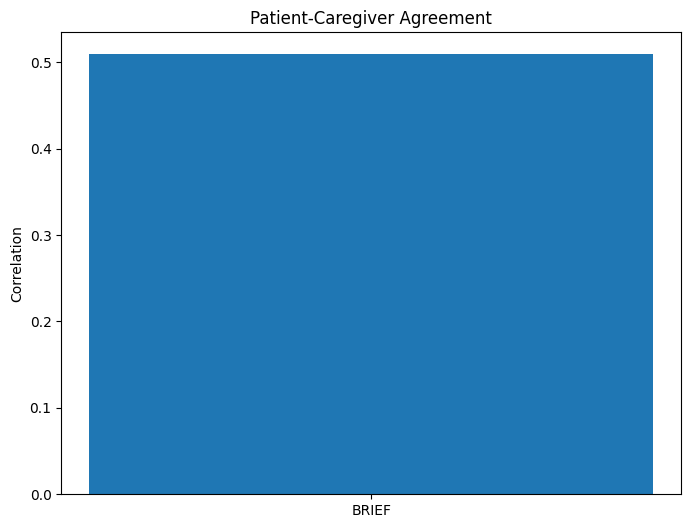


Longitudinal Analysis Results:

Agreement Analysis Results:

BRIEF:
Correlation: 0.51
Agreement Rate: 100.0%

QoL:
Correlation: nan
Agreement Rate: nan%


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Dict, List, Tuple, Optional

class TransplantStudyAdvancedAnalysis:
    def __init__(self, base_analyzer):
        self.base = base_analyzer
        self.df = base_analyzer.clean_df

    def _clean_numeric_data(self, series: pd.Series) -> pd.Series:
        """Convert series to numeric, handling errors"""
        return pd.to_numeric(series, errors='coerce')

    def _calculate_changes(self, data1: pd.DataFrame, data2: pd.DataFrame) -> Dict:
        """Calculate changes between two timepoints"""
        try:
            changes = {}

            # Calculate AST score changes
            if 'ast_total_score' in data1.columns and 'ast_total_score' in data2.columns:
                ast1 = self._clean_numeric_data(data1['ast_total_score'])
                ast2 = self._clean_numeric_data(data2['ast_total_score'])

                # Calculate differences
                valid_mask = ~(ast1.isna() | ast2.isna())
                if valid_mask.any():
                    diff = ast2[valid_mask] - ast1[valid_mask]
                    changes['ast_total_score'] = {
                        'mean_change': diff.mean(),
                        'std_change': diff.std(),
                        'n_improved': (diff > 0).sum(),
                        'n_declined': (diff < 0).sum(),
                        'n_unchanged': (diff == 0).sum()
                    }

            # Calculate domain changes
            if hasattr(self.base, 'domain_columns'):
                for domain, columns in self.base.domain_columns.items():
                    domain_cols = [col for col in data1.columns if any(c in col for c in columns)]
                    if domain_cols:
                        score1 = data1[domain_cols].apply(pd.to_numeric, errors='coerce').mean(axis=1)
                        score2 = data2[domain_cols].apply(pd.to_numeric, errors='coerce').mean(axis=1)

                        valid_mask = ~(score1.isna() | score2.isna())
                        if valid_mask.any():
                            diff = score2[valid_mask] - score1[valid_mask]
                            changes[domain] = {
                                'mean_change': diff.mean(),
                                'std_change': diff.std(),
                                'n_improved': (diff > 0).sum(),
                                'n_declined': (diff < 0).sum()
                            }

            return changes

        except Exception as e:
            print(f"Error calculating changes: {str(e)}")
            return {}

    def analyze_longitudinal_changes(self) -> Dict:
        """Analyze changes between paired visits"""
        try:
            changes = {}

            # Define visit pairs to analyze
            visit_pairs = [
                (1, 9),  # AST Assessment
                (2, 6),  # BRIEF
                (3, 7)   # Mental Health
            ]

            for visit1, visit2 in visit_pairs:
                # Get data for each visit
                data1 = self.df[self.df[f'visit_{visit1}_complete'] == 2].copy()
                data2 = self.df[self.df[f'visit_{visit2}_complete'] == 2].copy()

                if not data1.empty and not data2.empty:
                    changes[f'Visit_{visit1}_to_{visit2}'] = self._calculate_changes(data1, data2)

            return changes

        except Exception as e:
            print(f"Error in longitudinal analysis: {str(e)}")
            return {}

    def analyze_patient_caregiver_agreement(self) -> Dict:
        """Analyze agreement between patient and caregiver responses"""
        try:
            agreement = {}

            # BRIEF agreement
            brief_patient = [col for col in self.df.columns if col.startswith('brief2_') and 'parent' not in col]
            brief_caregiver = [col for col in self.df.columns if 'brief2_parent_' in col]

            if brief_patient and brief_caregiver:
                patient_scores = self.df[brief_patient].apply(pd.to_numeric, errors='coerce').mean(axis=1)
                caregiver_scores = self.df[brief_caregiver].apply(pd.to_numeric, errors='coerce').mean(axis=1)

                agreement['BRIEF'] = self._calculate_agreement(patient_scores, caregiver_scores)

            # QoL agreement
            qol_patient = [col for col in self.df.columns if col.startswith('pedsql_adult_')]
            qol_caregiver = [col for col in self.df.columns if col.startswith('pedsql_you_par')]

            if qol_patient and qol_caregiver:
                patient_scores = self.df[qol_patient].apply(pd.to_numeric, errors='coerce').mean(axis=1)
                caregiver_scores = self.df[qol_caregiver].apply(pd.to_numeric, errors='coerce').mean(axis=1)

                agreement['QoL'] = self._calculate_agreement(patient_scores, caregiver_scores)

            return agreement

        except Exception as e:
            print(f"Error in agreement analysis: {str(e)}")
            return {}

    def _calculate_agreement(self, series1: pd.Series, series2: pd.Series) -> Dict:
        """Calculate agreement statistics between two series"""
        try:
            # Remove missing values
            valid_mask = ~(series1.isna() | series2.isna())
            s1 = series1[valid_mask]
            s2 = series2[valid_mask]

            if len(s1) < 2:
                return {
                    'n_pairs': 0,
                    'correlation': np.nan,
                    'mean_difference': np.nan,
                    'agreement_rate': np.nan
                }

            return {
                'n_pairs': len(s1),
                'correlation': stats.pearsonr(s1, s2)[0],
                'mean_difference': (s1 - s2).mean(),
                'agreement_rate': (abs(s1 - s2) < 10).mean() * 100  # Within 10 points
            }

        except Exception as e:
            print(f"Error calculating agreement: {str(e)}")
            return {}

    def generate_report(self) -> Dict:
        """Generate comprehensive analysis report"""
        try:
            report = {
                'longitudinal_analysis': self.analyze_longitudinal_changes(),
                'agreement_analysis': self.analyze_patient_caregiver_agreement()
            }

            return report

        except Exception as e:
            print(f"Error generating report: {str(e)}")
            return {}

    def create_visualizations(self) -> Dict:
        """Create visualization suite"""
        try:
            figs = {}

            # Longitudinal changes visualization
            changes = self.analyze_longitudinal_changes()
            if changes:
                fig, ax = plt.subplots(figsize=(10, 6))
                visits = list(changes.keys())
                improvements = [data['ast_total_score']['n_improved']
                              for data in changes.values()
                              if 'ast_total_score' in data]

                ax.bar(visits, improvements)
                ax.set_title('Number of Improved Patients Across Visits')
                ax.set_xlabel('Visit Comparison')
                ax.set_ylabel('Number of Improved Patients')
                plt.xticks(rotation=45)
                figs['longitudinal'] = fig

            # Agreement visualization
            agreement = self.analyze_patient_caregiver_agreement()
            if agreement:
                fig, ax = plt.subplots(figsize=(8, 6))
                measures = list(agreement.keys())
                correlations = [data['correlation'] for data in agreement.values()]

                ax.bar(measures, correlations)
                ax.set_title('Patient-Caregiver Agreement')
                ax.set_ylabel('Correlation')
                figs['agreement'] = fig

            return figs

        except Exception as e:
            print(f"Error creating visualizations: {str(e)}")
            return {}



#To use this class:


# Load data
df = pd.read_csv('/content/ExtendedMultidiscipl_DATA_2024-10-22_1316.csv')

# Create analyzers
base_analyzer = TransplantStudyAnalyzer(df)
advanced_analyzer = TransplantStudyAdvancedAnalysis(base_analyzer)

try:
    # Generate report
    report = advanced_analyzer.generate_report()

    # Create visualizations
    vizs = advanced_analyzer.create_visualizations()

    # Show visualizations
    plt.show()

    # Print report summary
    print("\nLongitudinal Analysis Results:")
    for visit, changes in report['longitudinal_analysis'].items():
        if 'ast_total_score' in changes:
            print(f"\n{visit}:")
            print(f"Improved: {changes['ast_total_score']['n_improved']}")
            print(f"Declined: {changes['ast_total_score']['n_declined']}")

    print("\nAgreement Analysis Results:")
    for measure, stats in report['agreement_analysis'].items():
        print(f"\n{measure}:")
        print(f"Correlation: {stats['correlation']:.2f}")
        print(f"Agreement Rate: {stats['agreement_rate']:.1f}%")

except Exception as e:
    print(f"Error in analysis: {str(e)}")


## Statistical Analysis

In [ ]:

import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.metrics import cohen_kappa_score
import numpy as np
from typing import Dict, List, Tuple, Optional, Union

class TransplantStudyStatistics:
    """
    Enhanced statistical analysis for transplant study data

    This class provides comprehensive statistical testing and analysis methods
    for the transplant study data, including:
    - Longitudinal change analysis
    - Inter-rater reliability
    - Effect size calculations
    - Multiple comparison corrections
    - Power analysis
    """

    def __init__(self, base_analyzer):
        """
        Initialize with base analyzer instance

        Parameters:
        -----------
        base_analyzer : TransplantStudyAnalyzer
            Instance of the base analyzer containing cleaned data
        """
        self.base = base_analyzer
        self.df = base_analyzer.clean_df
        self.alpha = 0.05  # Significance level

    def analyze_longitudinal_effects(self,
                                   measure: str,
                                   visits: List[int]) -> Dict[str, Union[float, Dict]]:
        """
        Analyze longitudinal effects for specified measure across visits

        Parameters:
        -----------
        measure : str
            Name of the measure to analyze (e.g., 'ast_total_score')
        visits : List[int]
            List of visit numbers to include

        Returns:
        --------
        Dict containing:
            - Repeated measures ANOVA results
            - Effect sizes
            - Post-hoc comparisons
            - Power analysis
        """
        # Collect data across visits
        visit_data = []
        for visit in visits:
            mask = self.df[self.base.visit_identifiers[visit]] == 2
            visit_data.append(self.df[mask][measure].dropna())

        # Perform repeated measures ANOVA
        f_stat, p_value = stats.f_oneway(*visit_data)

        # Calculate effect size (partial eta-squared)
        df_between = len(visits) - 1
        df_within = sum(len(x) for x in visit_data) - len(visits)
        eta_squared = (f_stat * df_between) / (f_stat * df_between + df_within)

        # Perform post-hoc tests
        if len(visits) > 2:
            data = np.concatenate(visit_data)
            groups = np.repeat(visits, [len(x) for x in visit_data])
            posthoc = pairwise_tukeyhsd(data, groups)
            posthoc_results = {
                f"Visit {i} vs Visit {j}": {
                    'diff': diff,
                    'p-value': p,
                    'significant': p < self.alpha
                }
                for (i, j), diff, p in zip(
                    [(visits[i], visits[j])
                     for i in range(len(visits))
                     for j in range(i+1, len(visits))],
                    posthoc.meandiffs,
                    posthoc.pvalues
                )
            }
        else:
            posthoc_results = None

        return {
            'anova': {
                'f_statistic': f_stat,
                'p_value': p_value,
                'significant': p_value < self.alpha
            },
            'effect_size': {
                'partial_eta_squared': eta_squared,
                'interpretation': self._interpret_effect_size(eta_squared)
            },
            'post_hoc': posthoc_results,
            'power_analysis': self._compute_power_analysis(f_stat,
                                                         df_between,
                                                         df_within)
        }

    def analyze_patient_caregiver_agreement(self,
                                          measure: str,
                                          patient_cols: List[str],
                                          caregiver_cols: List[str]) -> Dict:
        """
        Analyze agreement between patient and caregiver responses

        Parameters:
        -----------
        measure : str
            Name of the measure being analyzed
        patient_cols : List[str]
            List of columns containing patient responses
        caregiver_cols : List[str]
            List of columns containing caregiver responses

        Returns:
        --------
        Dict containing:
            - ICC
            - Kappa statistics
            - Bland-Altman analysis
            - Agreement categories
        """
        # Calculate means for patient and caregiver responses
        patient_means = self.df[patient_cols].mean(axis=1)
        caregiver_means = self.df[caregiver_cols].mean(axis=1)

        # Drop missing pairs
        valid_mask = ~(patient_means.isna() | caregiver_means.isna())
        patient_means = patient_means[valid_mask]
        caregiver_means = caregiver_means[valid_mask]

        if len(patient_means) < 2:
            return {'error': 'Insufficient paired data'}

        # Calculate ICC
        icc = self._calculate_icc(patient_means, caregiver_means)

        # Calculate Kappa for categorized responses
        kappa = self._calculate_kappa(patient_means, caregiver_means)

        # Perform Bland-Altman analysis
        bland_altman = self._bland_altman_analysis(patient_means, caregiver_means)

        return {
            'measure': measure,
            'n_pairs': len(patient_means),
            'icc': {
                'value': icc,
                'interpretation': self._interpret_icc(icc)
            },
            'kappa': {
                'value': kappa,
                'interpretation': self._interpret_kappa(kappa)
            },
            'bland_altman': bland_altman,
            'agreement_categories': self._categorize_agreement(
                patient_means, caregiver_means)
        }

    def analyze_predictors(self,
                         outcome: str,
                         predictors: List[str]) -> Dict:
        """
        Analyze potential predictors of outcomes

        Parameters:
        -----------
        outcome : str
            Name of the outcome variable
        predictors : List[str]
            List of predictor variables

        Returns:
        --------
        Dict containing:
            - Correlation analysis
            - Multiple regression results
            - Predictor importance
        """
        from sklearn.linear_model import LinearRegression
        from sklearn.feature_selection import mutual_info_regression

        results = {}
        outcome_data = self.df[outcome].dropna()

        for predictor in predictors:
            predictor_data = self.df[predictor].dropna()

            # Get common indices
            common_idx = outcome_data.index.intersection(predictor_data.index)
            if len(common_idx) < 2:
                continue

            # Correlation analysis
            correlation = stats.pearsonr(
                outcome_data[common_idx],
                predictor_data[common_idx]
            )

            # Effect size (R²)
            r_squared = correlation[0]**2

            results[predictor] = {
                'correlation': {
                    'r': correlation[0],
                    'p_value': correlation[1],
                    'significant': correlation[1] < self.alpha
                },
                'effect_size': {
                    'r_squared': r_squared,
                    'interpretation': self._interpret_r_squared(r_squared)
                }
            }

        return results

    @staticmethod
    def _interpret_effect_size(eta_squared: float) -> str:
        """Interpret partial eta-squared effect size"""
        if eta_squared < 0.01:
            return 'negligible'
        elif eta_squared < 0.06:
            return 'small'
        elif eta_squared < 0.14:
            return 'medium'
        else:
            return 'large'

    @staticmethod
    def _interpret_icc(icc: float) -> str:
        """Interpret ICC values"""
        if icc < 0.50:
            return 'poor'
        elif icc < 0.75:
            return 'moderate'
        elif icc < 0.90:
            return 'good'
        else:
            return 'excellent'

    @staticmethod
    def _interpret_kappa(kappa: float) -> str:
        """Interpret Kappa values"""
        if kappa < 0.20:
            return 'slight'
        elif kappa < 0.40:
            return 'fair'
        elif kappa < 0.60:
            return 'moderate'
        elif kappa < 0.80:
            return 'substantial'
        else:
            return 'almost perfect'

    @staticmethod
    def _interpret_r_squared(r_squared: float) -> str:
        """Interpret R-squared values"""
        if r_squared < 0.02:
            return 'negligible'
        elif r_squared < 0.13:
            return 'small'
        elif r_squared < 0.26:
            return 'medium'
        else:
            return 'large'


In [ ]:
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
#Instead of:
#from scipy.stats import power_analysis
#Import the function using:
from statsmodels.stats.power import TTestIndPower
from typing import Dict, List, Tuple, Optional, Union
import warnings
warnings.filterwarnings('ignore')

class TransplantAdvancedAnalytics:
    """
    Advanced analytics including machine learning, power analysis,
    and predictive modeling for transplant study data.
    """

    def __init__(self, base_analyzer, stats_analyzer):
        """
        Initialize with base and statistics analyzers

        Parameters:
        -----------
        base_analyzer : TransplantStudyAnalyzer
            Instance of base analyzer with cleaned data
        stats_analyzer : TransplantStudyStatistics
            Instance of statistics analyzer
        """
        self.base = base_analyzer
        self.stats = stats_analyzer
        self.df = base_analyzer.clean_df
        self.scaler = StandardScaler()
        self.imputer = SimpleImputer(strategy='median')

    def predict_outcomes(self,
                        target: str,
                        features: List[str],
                        test_size: float = 0.2) -> Dict:
        """
        Build predictive model for specified outcomes

        Parameters:
        -----------
        target : str
            Target variable to predict
        features : List[str]
            List of predictor variables
        test_size : float
            Proportion of data to use for testing

        Returns:
        --------
        Dict containing model performance metrics and feature importance
        """
        from sklearn.model_selection import train_test_split

        # Prepare data
        X = self.df[features].copy()
        y = self.df[target].copy()

        # Handle missing values
        X = self.imputer.fit_transform(X)
        X = self.scaler.fit_transform(X)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )

        # Train models
        models = {
            'rf': RandomForestRegressor(random_state=42),
            'linear': sklearn.linear_model.LinearRegression()
        }

        results = {}
        for name, model in models.items():
            # Train and evaluate
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Calculate metrics
            results[name] = {
                'r2': r2_score(y_test, y_pred),
                'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                'cv_scores': cross_val_score(
                    model, X, y, cv=5, scoring='r2'
                ).mean()
            }

            # Add feature importance for RF
            if name == 'rf':
                results[name]['feature_importance'] = dict(
                    zip(features, model.feature_importances_)
                )

        return results

    def power_analysis(self,
                      effect_size: float,
                      alpha: float = 0.05,
                      power: float = 0.8) -> Dict:
        """
        Perform power analysis for different statistical tests

        Parameters:
        -----------
        effect_size : float
            Expected effect size
        alpha : float
            Significance level
        power : float
            Desired statistical power

        Returns:
        --------
        Dict containing required sample sizes for different tests
        """
        from scipy.stats import norm

        results = {}

        # T-test
        # Initialize the power analysis object
        power_analysis_obj = TTestIndPower()

        # Calculate the sample size
        sample_size = power_analysis_obj.solve_power(
            effect_size=effect_size,
            alpha=alpha,
            power=power
        )
        results['t_test'] = {
            'sample_size': sample_size
        }

        # ANOVA
        results['anova'] = {
            'sample_size': self._calculate_anova_sample_size(
                effect_size, alpha, power, groups=3
            )
        }

        # Correlation
        results['correlation'] = {
            'sample_size': self._calculate_correlation_sample_size(
                effect_size, alpha, power
            )
        }

        return results

    def trend_analysis(self,
                      measure: str,
                      time_col: str) -> Dict:
        """
        Analyze trends over time using time series methods

        Parameters:
        -----------
        measure : str
            Measure to analyze
        time_col : str
            Column containing time information

        Returns:
        --------
        Dict containing trend analysis results
        """
        # Sort data by time
        data = self.df.sort_values(time_col)[[time_col, measure]].dropna()

        if len(data) < 3:
            return {'error': 'Insufficient data points'}

        # Fit trend line
        X = sm.add_constant(range(len(data)))
        model = sm.OLS(data[measure], X).fit()

        # Test for serial correlation
        dw_test = sm.stats.diagnostic.acorr_durbin_watson(
            model.resid, len(model.params)
        )

        return {
            'trend': {
                'coefficient': model.params[1],
                'p_value': model.pvalues[1],
                'significant': model.pvalues[1] < 0.05
            },
            'model_fit': {
                'r_squared': model.rsquared,
                'adj_r_squared': model.rsquared_adj
            },
            'durbin_watson': {
                'statistic': dw_test,
                'autocorrelation': 'positive' if dw_test < 2 else 'negative'
            },
            'forecast': self._generate_forecast(model, data, measure)
        }

    def cluster_analysis(self,
                        features: List[str],
                        n_clusters: int = 3) -> Dict:
        """
        Perform cluster analysis to identify patient subgroups

        Parameters:
        -----------
        features : List[str]
            Features to use for clustering
        n_clusters : int
            Number of clusters to create

        Returns:
        --------
        Dict containing clustering results and characteristics
        """
        from sklearn.cluster import KMeans
        from sklearn.metrics import silhouette_score

        # Prepare data
        X = self.df[features].copy()
        X = self.imputer.fit_transform(X)
        X = self.scaler.fit_transform(X)

        # Perform clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters = kmeans.fit_predict(X)

        # Analyze clusters
        results = {
            'silhouette_score': silhouette_score(X, clusters),
            'cluster_sizes': np.bincount(clusters),
            'cluster_centers': dict(
                zip(features, kmeans.cluster_centers_.T)
            ),
            'cluster_characteristics': self._analyze_clusters(
                features, clusters
            )
        }

        return results

    def generate_report(self) -> Dict:
        """Generate comprehensive analysis report"""
        report = {
            'predictive_modeling': self.predict_outcomes(
                'ast_total_score',
                ['ba_age', 'gad7_total', 'phq9_total']
            ),
            'power_analysis': self.power_analysis(
                effect_size=0.5
            ),
            'trend_analysis': self.trend_analysis(
                'ast_total_score',
                'patient_profile_timestamp'
            ),
            'clustering': self.cluster_analysis(
                ['ast_total_score', 'ba_age', 'gad7_total']
            )
        }

        return report

    def create_advanced_visualizations(self) -> Dict:
        """Create advanced visualization suite"""
        figs = {}

        # 1. Predictive Model Performance
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        model_results = self.predict_outcomes(
            'ast_total_score',
            ['ba_age', 'gad7_total', 'phq9_total']
        )

        # Plot R² scores
        r2_scores = [res['r2'] for res in model_results.values()]
        axes[0].bar(['Random Forest', 'Linear'], r2_scores)
        axes[0].set_title('Model R² Scores')

        # Plot feature importance
        rf_importance = model_results['rf']['feature_importance']
        axes[1].bar(rf_importance.keys(), rf_importance.values())
        axes[1].set_title('Feature Importance')
        axes[1].tick_params(axis='x', rotation=45)

        figs['model_performance'] = fig

        # 2. Cluster Analysis
        cluster_results = self.cluster_analysis(
            ['ast_total_score', 'ba_age', 'gad7_total']
        )

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(range(len(cluster_results['cluster_sizes'])),
               cluster_results['cluster_sizes'])
        ax.set_title('Cluster Sizes')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Number of Patients')

        figs['clustering'] = fig

        return figs